# Bayesian Optimization for Color Mixing

#### Preparation and Installations 
If you don't have python and Jupyter Notebook installed on the local computer, we suggest install them via Anaconda (see https://docs.anaconda.com/anaconda/install/).

After installing basic python package and Jupyter Noteook, go to the directory of the downloaded sample code by <br>
> `cd C:\your_directory\BOB\` (example for windows)<br> 
> `cd your_directory/BOB/` (example for mac)<br>

Use `dir` or `ls` to check if folders and files in your current directory.
When reaching the code directory, type the following command line :<br>
> `pip install -r requirment.txt` <br> 

This should help you start to install Bayesian Optimization (`GpyOpt`) package and the other supporting packages (`Gpy`,`paramz` etc.)

#### Getting Started with Bayesian Optimization
The objective of this project is to find the best recipe (i.e., opening times of the three valves) that minimizes the difference between a mixed color and the reference color. We use the built-in `BayesianOptimization` function in `GpyOpt` package in this project. This function takes in the as the valve opening times as input variable $X$, and the correspoinding difference between measured RGB of the experimental trials and the target RGB as input variable $Y$, and then the Gaussian Process model (by default) in the algorithm tries to estimate the functional relationship between $X$ and $Y$ (_e.g._, $Y = f(X)$)

The input variable $X$ is a numpy array that contains all the prior experiments of valve opening times, in the format of: <br>
> [[$t_{A1}$, $t_{B1}$, $t_{C1}$],
>  [$t_{A2}$, $t_{B2}$, $t_{C2}$],
>  [$t_{A3}$, $t_{B3}$, $t_{C3}$]]

The values of the valve opening times are normalized values that are in the range of `0-1`, with `1` represents the highest valve opening time that one wants to explore. Please make sure that the array input into $X$ is normalized. Otherwise, the boundary conditions (_i.e._,  variable `bds` in `optimizer_func` is changed to consistent ranges).

The input variable $Y$ is another numpy array that contains the corresponding mean square errors between measured RGB of the experimental trials and the reference RGB of the target color. In this sample code, the range of RGB values are assumed as `0-256`. If experimental RGB readings are different from this range, we need to either scale the readings or change the range settings in the plotting functions. 

1. To get started in iteration 0, we need to first generate several initial random trials of  valve opening combinations, and measure the corresponding RGB values via the Arduino. These should be imported to the python script. The valve times are normalized and assigned to the input variable $X$, while he function `MSE_func(rgb_exp, rgb_ref)` should be used to calculate the input variable $Y$. These are used as the initial $X$ and $Y$ variables to train an `optimizer`, and then one can use `optimizer.suggest_next_locations()` to get suggestions on the next round of valve times. The variable `batch_size` is to specify number of suggestions per iteration.

2. From the second iteration onwards, the valve times should be always followed the suggestions from the previous iterations. However, the input $X$ and $Y$ should contain all the data from all prior experiments of all iterations. In other words, we need to append newly acquired data to the previous data in the numpy arrays as the inputs into `BayesianOptimization` in every new iterations. 

3. The optimization iterations should continue until you achieve a mixed color with sufficiently small difference to the target RGB (typically in 3-5 iterations)


#### Frequently Asked Questions:
- Can Bayesian Optimization interpolate and extrapolate from the existing observations? <br>
    Yes, Bayesian Optimization can predict unobserved points at both interpolated as well as extrapolated locations. It uses a surrogate model (_e.g._, Gaussian Process model in this case) to approximate the functional relationship between $X$ and $Y$ based on the existing observations, with the lowest uncertainty at the observed locations, and higher uncertainty at the unobserved locations that are far away from the existing observations. For different surrogate models, the approximation will be slightly different (especially when the number of observed data are limited). <br>


- What are the hyperparameters that can be tuned in the `BayesianOptimization` function? <br>
    Full information about `BayesianOptimization` function can be found via this link (https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html)
    - `acquisition_type` is the parameter that controls how the suggested acquictions should be evaluated. Common choices include ‘EI’, ‘MPI’, ‘LCB’, etc.
    - `model_type` is the parameter that choose the surrogate model. Several versions of Gaussian Process model are available, such as  ‘GP’, ‘sparseGP’, ‘warperdGP’, ‘RF’.



- How can I use the approximated function in the trained Bayesian optimizer to predict $Y$ from any given $X$? <br>
    After an `optimizer` is trained on existing observations, the funciton `optimizer.model.predict(X)` returns the approximated mean values and uncertainties of $Y$.



In [1]:
def RGB_func(t): 
    '''
    This is the 'fake' function to genration RGB from the t_A, t_B, t_C
    Please replace this function with the actual experimental data
    '''
    t = t.dot(np.array([[1,0.1,0.0],[0.0,0.8,0.1],[0.3,0.0,1]]))
    return (t+ 0.02* np.random.randn(*t.shape))*256

def MSE_func(RGB_exp,RGB_ref):
    '''
    Caclulate the metric for optimization: 
    Mean Square Error of experimental RGB measurements and the targeted RGB
    '''
    Y = []
    for i in range(len(RGB_exp)):
        Y.append([mean_squared_error(RGB_exp[i],RGB_ref)])
    return np.array(Y)

def barplot_RGB(RGB_ref,RGB_exp,title_string):

    plt.bar(np.arange(1)-0.25, [RGB_ref[0]], 0.25,  alpha=1, color='r')
    plt.bar(np.arange(1)-0.00, [RGB_ref[1]] , 0.25,  alpha=1, color='g')
    plt.bar(np.arange(1)+0.25, [RGB_ref[2]], 0.25,  alpha=1, color='b')

    plt.bar(np.transpose(np.arange(1,7)-0.25), RGB_exp[:,0], 0.25,  alpha=0.5, color='r')
    plt.bar(np.transpose(np.arange(1,7)+0.00),  RGB_exp[:,1], 0.25,  alpha=0.5, color='g')
    plt.bar(np.transpose(np.arange(1,7)+0.25), RGB_exp[:,2], 0.25,  alpha=0.5, color='b')
    #plt.xticks(y_pos, objects)
    plt.ylabel('RGB values [0 - 256]')
    plt.ylim(0,300)
    plt.title(title_string)
    plt.show()

def MSE_RGB_3Dplot(X, Y, title_string):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(X[:,0], X[:,1], X[:,2], c=np.squeeze(np.sqrt(Y)), linewidth=3,vmin=0, vmax=25)#plt.hot())
    cbar = fig.colorbar(img)
    cbar.set_label('RGB RMSE between ref and exp')
    ax.set(xlabel='t_A (sec)', ylabel='t_B (sec)', zlabel='t_C (sec)', title = title_string)
    ax.set_xlim3d(0, 1)
    ax.set_ylim3d(0, 1)
    ax.set_zlim3d(0, 1)
    ax.view_init(30, 360-60)
    plt.show()
    
    
def optimizer_func(X, Y, Batch_size):
    '''
    Bayesian Optimizer Function 
    
    Batch_size is the number of suggestions for the next rounds
    X should be the input variables
    Y should be the metric to be optimized
    '''
    #import GPy
   
    from GPyOpt.methods import BayesianOptimization
    bds = [{'name': 'x1', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 1)},
           {'name': 'x3', 'type': 'continuous', 'domain': (0, 1)},
          ]

    #kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)

    optimizer = BayesianOptimization(f=None, 
                                     domain=bds,
                                     model_type='GP',
                                     acquisition_type ='EI',
                                     acquisition_jitter = 0.01,
                                     X=X,
                                     Y=Y,
                                     evaluator_type = 'local_penalization',
                                     batch_size = Batch_size,
                                     normalize_Y= True
                                     #noise_var = 0.05**2,
                                     #kernel = kernel
                                     )
    return optimizer

### Initializaiton and BO iteration 0

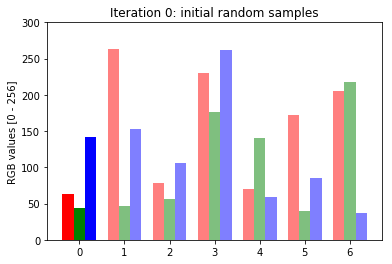

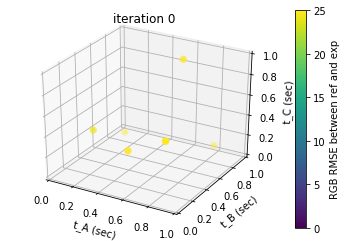

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.00146623 0.0431532  0.17836318]
 [0.01518022 0.03952385 0.11502895]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

# RGB_ref should be replaced by the reference RGB measurement   
RGB_ref = np.random.random(3)*256 #np.array([128, 56, 200])


Batch_size = 6 
#random sampling is required to initialize the search
X_init = []
for i in range(Batch_size):
    X_init.append(np.random.random(3))
X_init = np.array(X_init)


RGB_exp_init = RGB_func(X_init)# To be Replaced by real measurement data
Y_init = MSE_func(RGB_exp_init,RGB_ref)

optimizer_init = optimizer_func(X_init,Y_init,Batch_size)
next_acqui_1 = optimizer_init.suggest_next_locations()
targetRGB_mean, targetRGB_variance = optimizer_init.model.predict(next_acqui_1)

barplot_RGB(RGB_ref,RGB_exp_init,'Iteration 0: initial random samples')
MSE_RGB_3Dplot(X_init, Y_init,'iteration 0') 
print(next_acqui_1)


### BO iteration 2

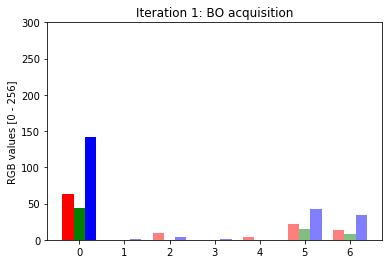

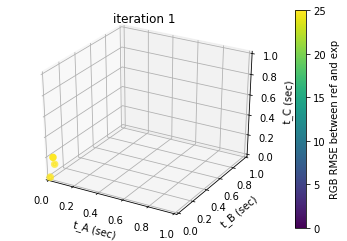

[[0.         0.         0.71701524]
 [0.01335586 0.252518   0.5272837 ]
 [0.00311991 0.13688518 0.99673573]
 [0.14394135 0.04553527 0.47778202]
 [0.01620902 0.37361931 0.34351239]
 [0.2423473  0.00270441 0.6229978 ]]


In [3]:
X1 = next_acqui_1

RGB_exp_1 = RGB_func(X1)# To be Replaced by real measurement data
Y1 = MSE_func(RGB_exp_1, RGB_ref)

optimizer_1 = optimizer_func(np.concatenate([X_init, X1]),\
                             np.concatenate([Y_init, Y1]),\
                             Batch_size)
next_acqui_2 = optimizer_1.suggest_next_locations()
    
barplot_RGB(RGB_ref,RGB_exp_1,'Iteration 1: BO acquisition')
MSE_RGB_3Dplot(X1, Y1, 'iteration 1') 

print(next_acqui_2)

### BO iteration 2

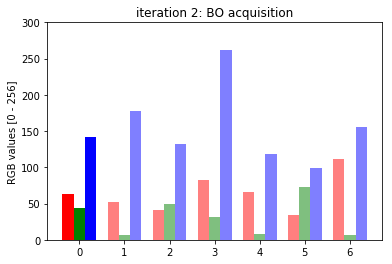

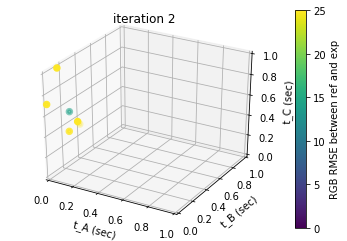

[[0.05881966 0.17131353 0.50688307]
 [0.04866809 0.07874721 0.52479851]
 [0.07669251 0.24299504 0.47556161]
 [0.08716783 0.18448147 0.4726865 ]
 [0.01298526 0.16434411 0.52628136]
 [0.02430402 0.17543068 0.58806297]]


In [4]:
X2 = next_acqui_2
RGB_exp_2 = RGB_func(X2)
Y2 = MSE_func(RGB_exp_2, RGB_ref)

optimizer_2 = optimizer_func(np.concatenate([X_init, X1, X2]),\
                             np.concatenate([Y_init, Y1, Y2]),\
                             Batch_size)    
next_acqui_3 = optimizer_2.suggest_next_locations()

barplot_RGB(RGB_ref,RGB_exp_2,'iteration 2: BO acquisition')
MSE_RGB_3Dplot(X2,  Y2, 'iteration 2') 

print(next_acqui_3)

### BO iteration 3

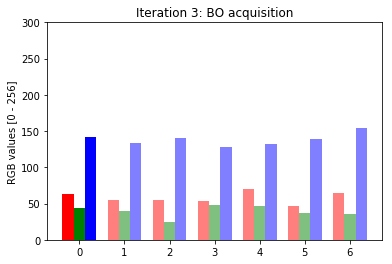

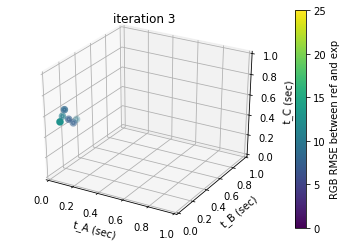

[[6.61054408e-02 1.76564115e-01 5.13258504e-01]
 [1.00087825e-01 2.11581190e-01 4.93819566e-01]
 [4.53281247e-04 1.64039079e-01 5.88105520e-01]
 [2.72123422e-02 1.57666400e-01 5.17202198e-01]
 [1.04676435e-01 1.61805953e-01 5.11376305e-01]
 [1.00982881e-01 1.10501476e-01 5.36039879e-01]]


In [5]:
X3 = next_acqui_3
RGB_exp_3 = RGB_func(X3)
Y3 = MSE_func(RGB_exp_3, RGB_ref)

optimizer_3 = optimizer_func(np.concatenate([X_init, X1, X2, X3]),\
                             np.concatenate([Y_init, Y1, Y2, Y3]),\
                             Batch_size)
next_acqui_4 = optimizer_3.suggest_next_locations()

barplot_RGB(RGB_ref,RGB_exp_3,'Iteration 3: BO acquisition')
MSE_RGB_3Dplot(X3, Y3,  'iteration 3') 
print(next_acqui_4)

### BO iteration 4

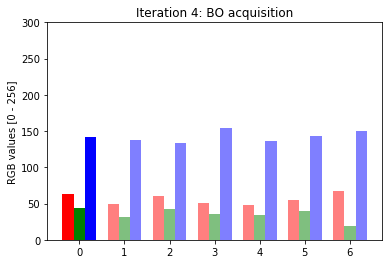

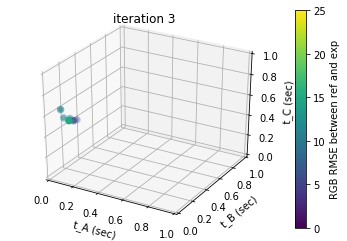

[[0.06558814 0.18250784 0.51542903]
 [0.09496044 0.21468669 0.48879808]
 [0.09584223 0.15225235 0.50499678]
 [0.04243089 0.16982447 0.55622421]
 [0.06217217 0.22086789 0.50748259]
 [0.11907353 0.16135735 0.53502683]]


In [6]:
X4 = next_acqui_4
RGB_exp_4 = RGB_func(X4)
Y4 = MSE_func(RGB_exp_4, RGB_ref)

optimizer_4 = optimizer_func(np.concatenate([X_init, X1, X2, X3, X4]),\
                             np.concatenate([Y_init, Y1, Y2, Y3, Y4]),\
                             Batch_size)
next_acqui_5 = optimizer_4.suggest_next_locations()

barplot_RGB(RGB_ref,RGB_exp_4,'Iteration 4: BO acquisition')
MSE_RGB_3Dplot(X4, Y4,  'iteration 3') 
print(next_acqui_5)


### 3D visualization of value time vs RMSE

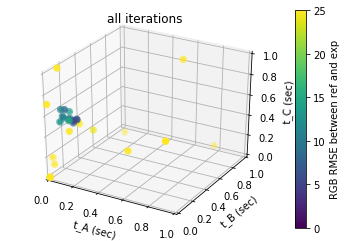

In [7]:
MSE_RGB_3Dplot(np.concatenate([X_init, X1, X2, X3, X4]), \
               np.concatenate([Y_init, Y1, Y2, Y3, Y4]), \
               'all iterations') 


### visualization of RGB values over BO iterations 

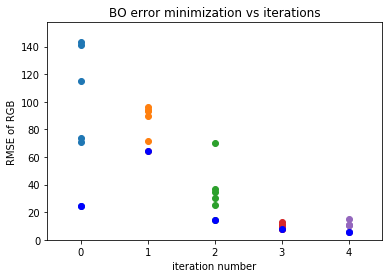

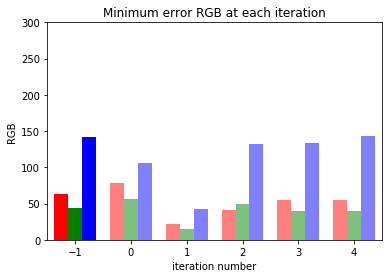

The optmized RGB values:  [21.66023329 15.57280253 42.48300267]
The recipes for optmized RGB:  [0.00146623 0.0431532  0.17836318]


In [8]:
Y_all_iterations = [Y_init, Y1, Y2, Y3, Y4]
for i in np.arange(len(Y_all_iterations)):
    plt.scatter(np.ones(6)*i,np.sqrt(np.transpose(Y_all_iterations[i])[0]))
    plt.scatter(i,np.sqrt(np.min(np.transpose(Y_all_iterations[i])[0])),color = 'b')
    plt.xlim(-0.5,len(Y_all_iterations)-0.5,1)
    plt.ylim(0, np.sqrt(np.max(Y_all_iterations))*1.1)
    plt.title("BO error minimization vs iterations")
    plt.xlabel("iteration number")
    plt.ylabel("RMSE of RGB")
plt.show()

X_all_iterations = [X_init, X1, X2, X3, X4]
RGB_exp = [RGB_exp_init, RGB_exp_1, RGB_exp_2, RGB_exp_3, RGB_exp_4]
RGB_mins = []
X_mins = []
from operator import itemgetter
for i in np.arange(len(RGB_exp)):
    idx_min = min(enumerate(np.transpose(Y_all_iterations[i])[0]), key=itemgetter(1))[0]
    RGB_mins.append(RGB_exp[i][idx_min])
    X_mins.append(X_all_iterations[i][idx_min])
    plt.bar(-1-0.25, RGB_ref[0], 0.25,  alpha=1, color='r')
    plt.bar(-1+0.00, RGB_ref[1], 0.25,  alpha=1, color='g')
    plt.bar(-1+0.25, RGB_ref[2], 0.25,  alpha=1, color='b')

    plt.bar(i-0.25, RGB_exp[i][idx_min][0], 0.25,  alpha=0.5, color='r')
    plt.bar(i, RGB_exp[i][idx_min][1], 0.25,  alpha=0.5, color='g')
    plt.bar(i+0.25, RGB_exp[i][idx_min][2], 0.25,  alpha=0.5, color='b')
    plt.xlim(-0.5-1,len(Y_all_iterations)-0.5,1)
    plt.ylim(0,300)
    plt.title("Minimum error RGB at each iteration")
    plt.xlabel("iteration number")
    plt.ylabel("RGB")
plt.show()
print('The optmized RGB values: ', np.min(RGB_mins, axis =0))
print('The recipes for optmized RGB: ', np.min(X_mins, axis =0))

### Output the top five recipes to get the closest RGB reference

In [9]:
import pandas as pd
y = optimizer_4.get_evaluations()[1]
x = optimizer_4.get_evaluations()[0]
evals = pd.DataFrame(np.transpose(np.append(np.transpose(x), np.sqrt(np.transpose(y)), axis=0)))
evals.sort_values(by=[3, 0,1,2]).head(5)

,0,1,2,3
28,0.104676,0.161806,0.511376,5.329971
25,0.100088,0.211581,0.493820,5.715253
18,0.058820,0.171314,0.506883,7.504564
21,0.087168,0.184481,0.472687,7.577140
23,0.024304,0.175431,0.588063,8.562619
